In [1]:
import librosa
from scipy.fftpack import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import soundfile as sf
import sklearn
import pandas as pd
import os, wave
import pickle

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = '/kaggle/input/covid19-cough-audio-classification/'
file = "metadata_compiled.csv"
df=pd.read_csv(data+file,sep=",")
full_df = df
#full_df

In [3]:
Covid_data = pd.DataFrame()
Covid_data['uuid'] = df['uuid']
Covid_data['status'] = df['status']
Covid_data = Covid_data.dropna()
#Covid_data

In [4]:
df = Covid_data[Covid_data['status']=="healthy"]
remove_n = 4000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [5]:
Covid_data  = pd.concat([Covid_data, df_subset])
Covid_data = Covid_data.drop_duplicates(keep=False)
#Covid_data

In [6]:
Covid_data.drop(['status'], axis = 1)

,uuid
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b
7,001d8e33-a4af-4edb-98ba-b03f891d9a6c
12,0029d048-898a-4c70-89c7-0815cdcf7391
13,002d28bc-7806-4dfb-9c9b-afa8cb623cac
17,00357712-dd5a-4c0a-90a4-39f1f4b9d5fd
...,...
27531,ffc4f2e1-ff4f-422b-9a04-f9858d4967fb
27538,ffdf80c2-be81-4fc9-9484-a72223cfc87d
27539,ffe0658f-bade-4654-ad79-40a468aabb03
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1


In [7]:
data = pd.DataFrame()
data = full_df

In [8]:
data = pd.merge(Covid_data, data, left_on = 'uuid', right_on = 'uuid') # Merge the full dataset with the ones selected for the model

In [9]:
# Convert all NaN values to None/False and drop NaN values
data.dropna(subset = ['SNR'], inplace = True)
data.dropna(subset = ['cough_detected'], inplace = True)
data.dropna(subset = ['status_x'], inplace = True)
data['quality_4'].fillna('None', inplace = True)
data['cough_type_4'].fillna('None', inplace = True)
data['dyspnea_4'].fillna(False, inplace = True)
data['wheezing_4'].fillna(False, inplace = True)
data['stridor_4'].fillna(False, inplace = True)
data['choking_4'].fillna(False, inplace = True)
data['congestion_4'].fillna(False, inplace = True)
data['diagnosis_4'].fillna('None', inplace = True)
data['severity_4'].fillna('None', inplace = True)
data['fever_muscle_pain'].fillna(False, inplace = True)
data['respiratory_condition'].fillna(False, inplace = True)
data['gender'].fillna('None', inplace = True)


In [10]:
# One hot encode all of the  columns with categorical variables 
sev_cat = pd.get_dummies(data['severity_4']) # mild, severe, psuedocough, unknown, None
diag_cat = pd.get_dummies(data['diagnosis_4']) # upper_infection, obstructive_disease, lower_infection, healthy_cough, COVID-19, None
type_cat = pd.get_dummies(data['cough_type_4']) # wet, dry, unknown, None
quality_cat = pd.get_dummies(data['quality_4']) # poor, ok, good, None

In [11]:
# Map and convert all of the columns with boolean values
data['congestion_4'] = data['congestion_4'].astype(int)
data['choking_4'] = data['choking_4'].astype(int)
data['stridor_4'] = data['stridor_4'].astype(int)
data['wheezing_4'] = data['wheezing_4'].astype(int)
data['dyspnea_4'] = data['dyspnea_4'].astype(int)
data['fever_muscle_pain'] = data['fever_muscle_pain'].astype(int)
data['respiratory_condition'] = data['respiratory_condition'].astype(int)

In [12]:
# Combine all the nominal/categorical columns and drop 'None' and the original categorical column names
merged_data = pd.concat([data, sev_cat, diag_cat, type_cat, quality_cat], axis = 'columns').drop(['severity_4', 'diagnosis_4', 'cough_type_4', 'quality_4', 'None'], axis = 'columns')

# Drop unecessary columns (Columns not being used at all/anymore)
merged_data = merged_data.drop(['severity_1','severity_2','severity_3',
                               'diagnosis_1','diagnosis_2','diagnosis_3',
                               'congestion_1','congestion_2','congestion_3',
                               'choking_1','choking_2','choking_3',
                               'stridor_1','stridor_2','stridor_3',
                               'wheezing_1','wheezing_2','wheezing_3',
                               'dyspnea_1','dyspnea_2','dyspnea_3',
                               'cough_type_1','cough_type_2','cough_type_3',
                               'quality_1','quality_2','quality_3',
                               'nothing_1','nothing_2','nothing_3',
                               'nothing_4','status_y',
                               'datetime','latitude', 'longitude'], axis = 'columns')

In [13]:
# One-hot (label) encode status column: symptomatic = 2, healthy = 1, COVID-19 = 0 
from sklearn.preprocessing import LabelEncoder

values = merged_data['status_x']

label_encoder = LabelEncoder()
merged_data['status_x'] = label_encoder.fit_transform(merged_data['status_x'])

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import matplotlib.pyplot as plt

symptomatic = 2, healthy = 1, COVID-19 = 0 

In [15]:
# First Set
X = merged_data[['respiratory_condition','fever_muscle_pain', 
                 'dyspnea_4', 'wheezing_4','stridor_4', 'choking_4', 'congestion_4', 
                 'mild', 'pseudocough','severe', 'unknown', 'COVID-19', 'healthy_cough', 
                 'lower_infection','obstructive_disease', 'upper_infection', 'dry', 'unknown', 
                 'wet','good', 'no_cough', 'ok', 'poor']]

'''
# Second Set 
X = merged_data[['cough_detected','respiratory_condition','fever_muscle_pain', 
                 'dyspnea_4', 'wheezing_4','stridor_4', 'choking_4', 'congestion_4', 
                 'mild', 'pseudocough','severe', 'unknown', 'COVID-19', 'healthy_cough', 
                 'lower_infection','obstructive_disease', 'upper_infection', 'dry', 'unknown', 
                 'wet','good', 'no_cough', 'ok', 'poor']]
'''

y = merged_data['status_x']

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
#X_train_s = scaler.fit_transform(X_train)
#X_test_s = scaler.fit_transform(X_test)

Real test set values

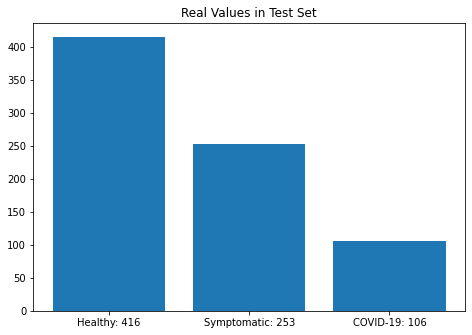

In [16]:
real_covid = 0
real_sym = 0
real_good = 0

for i in y_test:
    if i == 1:
        real_good += 1
    if i == 2:
        real_sym += 1
    if i == 0:
        real_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(real_good), 'Symptomatic: ' + str(real_sym), 'COVID-19: ' + str(real_covid)]
y = [real_good, real_sym, real_covid]
ax.bar(x,y)
plt.title("Real Values in Test Set")
plt.show()

Linear Regression

Score:  0.005735696158787995


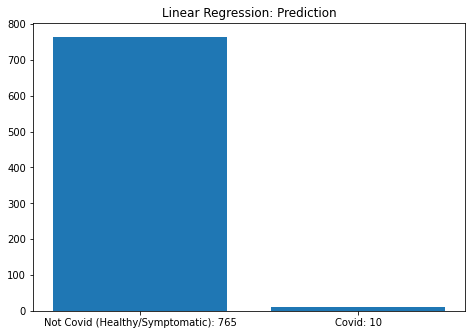

In [17]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print("Score: ", reg.score(X_test, y_test))
reg_pred = reg.predict(X_test)
#print("Prediction: ", reg_pred)

count_covid = 0
count_good = 0
for i in reg_pred:
    if i > 1:
        count_good += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Not Covid (Healthy/Symptomatic): ' + str(count_good), 'Covid: ' + str(count_covid)]
y = [count_good, count_covid]
ax.bar(x,y)
plt.title("Linear Regression: Prediction")
plt.show()

Neural Network

Score:  0.6129032258064516


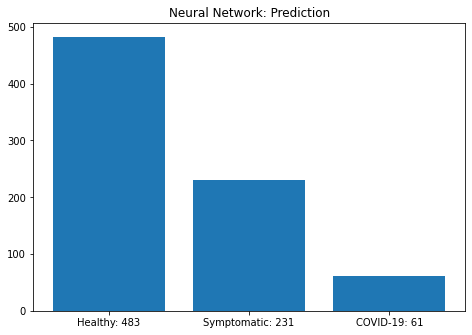

In [18]:
from sklearn.neural_network import MLPClassifier
neural_model = MLPClassifier(hidden_layer_sizes=(64, 64, 64), max_iter = 1000, solver = 'lbfgs')
neural_model.fit(X_train ,y_train)
print("Score: ", neural_model.score(X_test, y_test))
neural_pred = neural_model.predict(X_test)
#print("Prediction: ", neural_pred)

count_covid = 0
count_good = 0
count_sym = 0
for i in neural_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("Neural Network: Prediction")
plt.show()

Decision Tree

0.6129032258064516


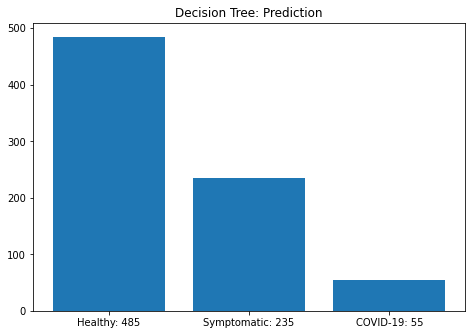

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train, y_train)
print(tree_model.score(X_test, y_test))
tree_pred = tree_model.predict(X_test)
#print("Prediction: ", tree_pred)

count_covid = 0
count_good = 0
count_sym = 0
for i in tree_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("Decision Tree: Prediction")
plt.show()

Random Forest

0.5780645161290323


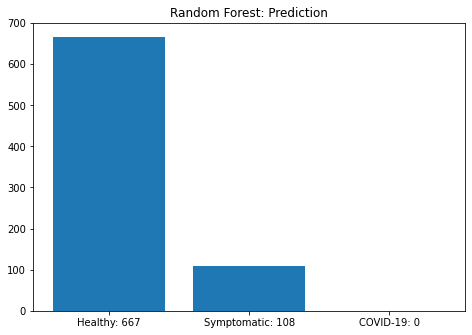

In [20]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators=100,
        max_depth=3, min_samples_leaf=10)
forest_model.fit(X_train, y_train)
print(forest_model.score(X_test, y_test))
forest_pred = forest_model.predict(X_test)
#print("Prediction: ", forest_pred)

count_covid = 0
count_good = 0
count_sym = 0
for i in forest_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("Random Forest: Prediction")
plt.show()

Naive Bayes

0.5483870967741935


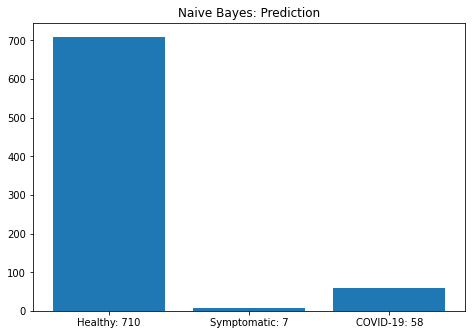

In [21]:
from sklearn.naive_bayes import GaussianNB
naive_model = GaussianNB()
naive_model.fit(X_train, y_train)
print(naive_model.score(X_test, y_test))
naive_pred = naive_model.predict(X_test)

count_covid = 0
count_good = 0
count_sym = 0
for i in naive_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("Naive Bayes: Prediction")
plt.show()

SVM (Feature Scaling)

0.6154838709677419


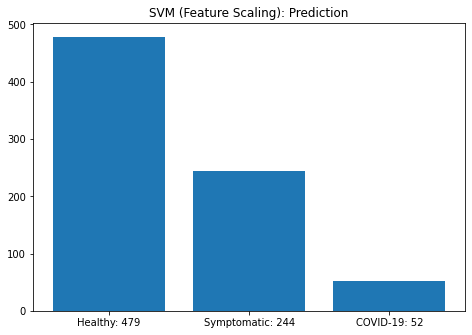

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

svc_model = make_pipeline(StandardScaler(), SVC(gamma = 'auto'))
svc_model.fit(X_train, y_train)
print(svc_model.score(X_test, y_test))
svc_pred = svc_model.predict(X_test)

count_covid = 0
count_good = 0
count_sym = 0
for i in svc_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("SVM (Feature Scaling): Prediction")
plt.show()

KNeighbours (Feature Scaling)

0.607741935483871


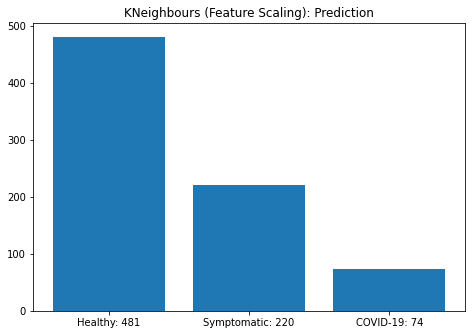

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

kn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 9))
kn_model.fit(X_train, y_train)
print(kn_model.score(X_test, y_test))
kn_pred = kn_model.predict(X_test)

count_covid = 0
count_good = 0
count_sym = 0
for i in kn_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("KNeighbours (Feature Scaling): Prediction")
plt.show()

Ensemble

0.607741935483871


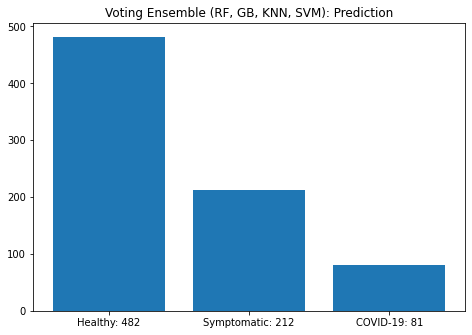

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm

clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = GaussianNB()
clf3 = KNeighborsClassifier(n_neighbors = 9)
clf4 = svm.SVC()

eclf = VotingClassifier(estimators = [('rf', clf1),
                                      ('gnb', clf2),
                                       ('knn', clf3),
                                      ('svm', clf4)], voting = 'hard')
eclf = eclf.fit(X_train, y_train)
print(eclf.score(X_test, y_test))
eclf_pred = eclf.predict(X_test)

count_covid = 0
count_good = 0
count_sym = 0
for i in eclf_pred:
    if i == 1:
        count_good += 1
    elif i == 2:
        count_sym += 1
    else:
        count_covid += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Healthy: ' + str(count_good), 'Symptomatic: ' + str(count_sym), 'COVID-19: ' + str(count_covid)]
y = [count_good, count_sym, count_covid]
ax.bar(x,y)
plt.title("Voting Ensemble (RF, GB, KNN, SVM): Prediction")
plt.show()